## 1. Import libraries and load the dataset 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pmd
from statsmodels.tsa.api import DynamicFactorMQ
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [26]:
# Load the dataset
df = pd.read_csv("./USDT.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df['Vol.'] = df['Vol.'].str.replace('K', 'e3')
df['Vol.'] = df['Vol.'].str.replace('M', 'e6')
df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
df

,Price,Vol.
Date,,
2017-12-01,1.0100,457320.0
2017-12-02,0.9959,970820.0
2017-12-03,0.9977,1300000.0
2017-12-04,1.0000,2910000.0
2017-12-05,1.0000,1740000.0
...,...,...
2023-06-12,1.0000,111560000.0
2023-06-13,0.9999,80350000.0
2023-06-14,0.9998,96430000.0


## 2. Split the data into training, test and validate sets

In [27]:
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1213, 2)
Test shape: (606, 2)
Validate shape: (204, 2)


In [28]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1416, 2)
Test shape: (404, 2)
Validate shape: (203, 2)


In [29]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1213, 2)
Test shape: (404, 2)
Validate shape: (406, 2)


## 3. Perform Dynamic Factor Model

### 3.1 Build and fit train data into Dynamic Factor Model

In [30]:
features = ['Price']
df_model = DynamicFactorMQ(endog=train_data, factors=2, factor_orders=1, idiosyncratic_ar1=True)
df_model_fit = df_model.fit(maxiter=100, disp=True)
df_model_fit.summary()

EM start iterations, llf=-3288.4
EM iteration 2, llf=-1507.9, convergence criterion=0.74246
EM iteration 3, llf=-1507.9, convergence criterion=6.3382e-07
EM converged at iteration 3, llf=-1507.9, convergence criterion=6.3382e-07 < tolerance=1e-06


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Dynamic Factor Results                              
===================================================================================
Dep. Variable:           ['Price', 'Vol.']   No. Observations:                 1213
Model:                Dynamic Factor Model   Log Likelihood               -1507.867
                   + 2 factors in 2 blocks   AIC                           3039.734
                     + AR(1) idiosyncratic   BIC                           3100.945
Date:                     Fri, 16 Jun 2023   HQIC                          3062.780
Time:                             23:41:29   EM Iterations                        3
Sample:                                  0                                         
                                    - 1213                                         
Covariance Type:              Not computed                                         
                          Observation equation:                           
==========================================================================
Factor loadings:          0          1    idiosyncratic: AR(1)        var.
--------------------------------------------------------------------------
           Price      -0.71      -0.50                   -0.00        0.00
            Vol.      -0.71       0.50                   -0.00        0.00
       Transition: Factor block 0      
=======================================
                 L1.0    error variance
---------------------------------------
         0       0.90              0.20
       Transition: Factor block 1      
=======================================
                 L1.1    error variance
---------------------------------------
         1       0.89              0.42
=======================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [31]:
def evaluate_dynamic_factor_model(data, start, end):
    pred = df_model_fit.predict(start=start, end=end)
    data = data[features]
    pred = pred[features]
    mse = mean_squared_error(data, pred)
    mae = mean_absolute_error(data, pred)
    mape = mean_absolute_percentage_error(data, pred)
    rmse = mean_squared_error(data, pred, squared=False)
    return pred, mse, mae, mape, rmse

### 3.2 Evaluate on Validate data

In [32]:
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaluate_dynamic_factor_model(val_data, start=len(df)-val_size+1, end=len(df))

print("Price predict on validate data:", y_pred_val)

Price predict on validate data:          Price
1618  1.000296
1619  1.000296
1620  1.000296
1621  1.000296
1622  1.000296
...        ...
2019  1.000296
2020  1.000296
2021  1.000296
2022  1.000296
2023  1.000296

[406 rows x 1 columns]


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 3.3 Evaluate on Test data

In [33]:
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaluate_dynamic_factor_model(test_data, start=train_size+1, end=train_size+test_size)
print("Price predict on test data:", y_pred_test)

Price predict on test data:          Price
1214  1.000066
1215  1.000129
1216  1.000182
1217  1.000224
1218  1.000259
...        ...
1613  1.000296
1614  1.000296
1615  1.000296
1616  1.000296
1617  1.000296

[404 rows x 1 columns]


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 3.4 Predict price for the next 30 days

In [34]:
last_index = len(df)

date_range = pd.date_range(start=df.index[-1], periods=30, freq='D')

y_next_30_days = df_model_fit.predict(start=len(df)+1, end=len(df)+30)[features]

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted closing prices for the next 30 days:
         Price
2024  1.000296
2025  1.000296
2026  1.000296
2027  1.000296
2028  1.000296
2029  1.000296
2030  1.000296
2031  1.000296
2032  1.000296
2033  1.000296
2034  1.000296
2035  1.000296
2036  1.000296
2037  1.000296
2038  1.000296
2039  1.000296
2040  1.000296
2041  1.000296
2042  1.000296
2043  1.000296
2044  1.000296
2045  1.000296
2046  1.000296
2047  1.000296
2048  1.000296
2049  1.000296
2050  1.000296
2051  1.000296
2052  1.000296
2053  1.000296


### 4.  Evaluate accuracy validate, test data

In [35]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

acc = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(acc)

                   MSE       MAE      MAPE      RMSE
Validate  7.289650e-07  0.000499  0.000499  0.000854
Test      1.564693e-07  0.000274  0.000274  0.000396


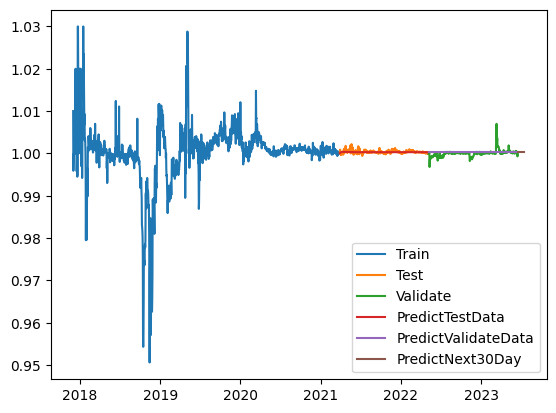

In [36]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])

plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(date_range, y_next_30_days)

plt.legend(['Train', 'Test', 'Validate','PredictTestData', 'PredictValidateData','PredictNext30Day'])
plt.show()